# Automatic rendering of Pyro models

In this tutorial we will demonstrate how to create beautiful visualizations of your probabilistic graphical models using [pyro.render_model()](https://docs.pyro.ai/en/latest/infer.util.html#pyro.infer.inspect.render_model).

In [1]:
import os
import torch
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.6')

## A Simple Example

The visualization interface can be readily used with your models:

In [2]:
def model(data):
    m = pyro.sample("m", dist.Normal(0, 1))
    sd = pyro.sample("sd", dist.LogNormal(m, 1))
    with pyro.plate("N", len(data)):
        pyro.sample("obs", dist.Normal(m, sd), obs=data)

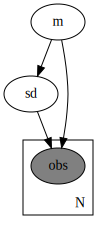

In [3]:
data = torch.ones(10)
pyro.render_model(model, model_args=(data,))

The visualization can be saved to a file by providing `filename='path'` to `pyro.render_model`. You can use different formats such as PDF or PNG by changing the filename's suffix.
When not saving to a file (`filename=None`), you can also change the format with `graph.format = 'pdf'` where `graph` is the object returned by `pyro.render_model`.

In [4]:
graph = pyro.render_model(model, model_args=(data,), filename="model.pdf")

## Tweaking the visualization

As `pyro.render_model` returns an object of type `graphviz.dot.Digraph`, you can further improve the visualization of this graph.
For example, you could use the [unflatten preprocessor](https://graphviz.readthedocs.io/en/stable/api.html#graphviz.unflatten) to improve the layout aspect ratio for more complex models.

In [5]:
def mace(positions, annotations):
    """
    This model corresponds to the plate diagram in Figure 3 of https://www.aclweb.org/anthology/Q18-1040.pdf.
    """
    num_annotators = int(torch.max(positions)) + 1
    num_classes = int(torch.max(annotations)) + 1
    num_items, num_positions = annotations.shape

    with pyro.plate("annotator", num_annotators):
        epsilon = pyro.sample("ε", dist.Dirichlet(torch.full((num_classes,), 10.)))
        theta = pyro.sample("θ", dist.Beta(0.5, 0.5))

    with pyro.plate("item", num_items, dim=-2):
        # NB: using constant logits for discrete uniform prior
        # (NumPyro does not have DiscreteUniform distribution yet)
        c = pyro.sample("c", dist.Categorical(logits=torch.zeros(num_classes)))

        with pyro.plate("position", num_positions):
            s = pyro.sample("s", dist.Bernoulli(1 - theta[positions]))
            probs = torch.where(
                s[..., None] == 0, F.one_hot(c, num_classes).float(), epsilon[positions]
            )
            pyro.sample("y", dist.Categorical(probs), obs=annotations)


positions = torch.tensor([1, 1, 1, 2, 3, 4, 5])
# fmt: off
annotations = torch.tensor([
    [1, 3, 1, 2, 2, 2, 1, 3, 2, 2, 4, 2, 1, 2, 1,
     1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
     1, 3, 1, 2, 2, 4, 2, 2, 3, 1, 1, 1, 2, 1, 2],
    [1, 3, 1, 2, 2, 2, 2, 3, 2, 3, 4, 2, 1, 2, 2,
     1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1, 1,
     1, 3, 1, 2, 2, 3, 2, 3, 3, 1, 1, 2, 3, 2, 2],
    [1, 3, 2, 2, 2, 2, 2, 3, 2, 2, 4, 2, 1, 2, 1,
     1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2,
     1, 3, 1, 2, 2, 3, 1, 2, 3, 1, 1, 1, 2, 1, 2],
    [1, 4, 2, 3, 3, 3, 2, 3, 2, 2, 4, 3, 1, 3, 1,
     2, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 2, 1, 1, 1,
     1, 3, 1, 2, 3, 4, 2, 3, 3, 1, 1, 2, 2, 1, 2],
    [1, 3, 1, 1, 2, 3, 1, 4, 2, 2, 4, 3, 1, 2, 1,
     1, 1, 1, 2, 3, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
     1, 2, 1, 2, 2, 3, 2, 2, 4, 1, 1, 1, 2, 1, 2],
    [1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 4, 4, 1, 1, 1,
     1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2,
     1, 3, 1, 2, 3, 4, 3, 3, 3, 1, 1, 1, 2, 1, 2],
    [1, 4, 2, 1, 2, 2, 1, 3, 3, 3, 4, 3, 1, 2, 1,
     1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1,
     1, 3, 1, 2, 2, 3, 2, 3, 2, 1, 1, 1, 2, 1, 2],
]).T
# fmt: on

# we subtract 1 because the first index starts with 0 in Python
positions -= 1
annotations -= 1

mace_graph = pyro.render_model(mace, model_args=(positions, annotations))

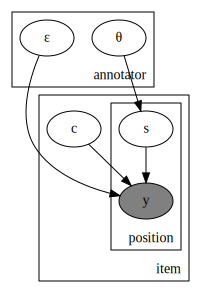

In [6]:
# default layout
mace_graph

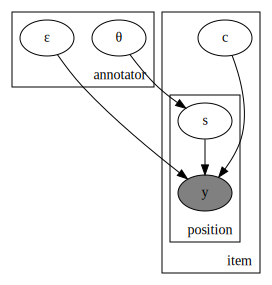

In [7]:
# layout after processing the layout with unflatten
mace_graph.unflatten(stagger=2)

## Rendering the parameters

We can render the parameters defined as `pyro.param` by setting `render_params=True` in `pyro.render_model`. 

In [8]:
def model(data):
    sigma = pyro.param("sigma", torch.tensor([1.]), constraint=constraints.positive)
    mu = pyro.param("mu", torch.tensor([0.]))
    x = pyro.sample("x", dist.Normal(mu, sigma))
    y = pyro.sample("y", dist.LogNormal(x, 1))
    with pyro.plate("N", len(data)):
        pyro.sample("z", dist.Normal(x, y), obs=data)

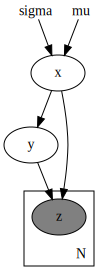

In [9]:
data = torch.ones(10)
pyro.render_model(model, model_args=(data,), render_params=True)

## Distribution and Constraint annotations

It is possible to display the distribution of each RV in the generated plot by providing `render_distributions=True` when calling `pyro.render_model`. The constraints associated with parameters are also displayed when `render_distributions=True`.

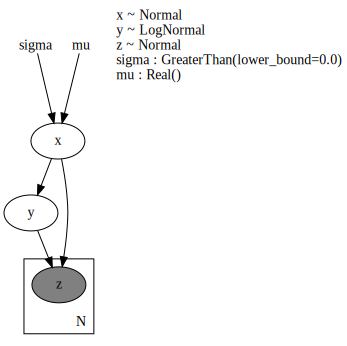

In [10]:
data = torch.ones(10)
pyro.render_model(model, model_args=(data,), render_params=True ,render_distributions=True)

In the above plot **'~'** denotes the distribution of RV and **'$\in$'** denotes the constraint of parameter.

## Overlapping non-nested plates

Note that overlapping non-nested plates may be drawn as multiple rectangles.

In [11]:
def model():
    plate1 = pyro.plate("plate1", 2, dim=-2)
    plate2 = pyro.plate("plate2", 3, dim=-1)
    with plate1:
        x = pyro.sample("x", dist.Normal(0, 1))
    with plate1, plate2:
        y = pyro.sample("y", dist.Normal(x, 1))
    with plate2:
        pyro.sample("z", dist.Normal(y.sum(-2, True), 1), obs=torch.zeros(3))

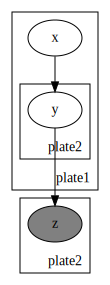

In [12]:
pyro.render_model(model)

## Semisupervised models

Pyro allows semisupervised models by allowing different sets of `*args,**kwargs` to be passed to a model. You can render semisupervised models by passing a list of different tuples `model_args` and/or a list of different `model_kwargs` to denote the different ways you use a model.

In [13]:
def model(x, y=None):
    with pyro.plate("N", 2):
        z = pyro.sample("z", dist.Normal(0, 1))
        y = pyro.sample("y", dist.Normal(0, 1), obs=y)
        pyro.sample("x", dist.Normal(y + z, 1), obs=x)

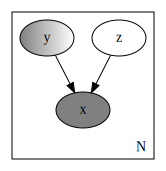

In [14]:
pyro.render_model(
    model,
    model_kwargs=[
        {"x": torch.zeros(2)},
        {"x": torch.zeros(2), "y": torch.zeros(2)},
    ]
)